# Projet 5 - Segmentez des clients d'un site e-commerce

# Simulation pour déterminer la fréquence nécessaire de mise à jour

## 1/ Chargement des librairies

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from datetime import datetime

sns.set_style('darkgrid')

## 2/ Chargement du jeu de données

In [25]:
file = 'C:/Users/raflg/Downloads/OpenClassrooms/Projet 5/'
data_path = file + 'merge_final.csv'

merge_final = pd.read_csv(data_path)
merge_final

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,review_score,payment_value,order_item_id,customer_unique_id,delivery_duration,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_sequential_1.0,payment_sequential_2.0,payment_sequential_3+
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-10,4.0,18.12,1.0,7c396fd4830fd04220f754e42b4e5bff,8,0,1,0,0,1,0,0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-10,4.0,2.00,1.0,7c396fd4830fd04220f754e42b4e5bff,8,0,0,0,1,0,0,1
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-10,4.0,18.59,1.0,7c396fd4830fd04220f754e42b4e5bff,8,0,0,0,1,0,1,0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-08-07,4.0,141.46,1.0,af07308b275d755c9edb36a90c618231,14,1,0,0,0,1,0,0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-17,5.0,179.12,1.0,3a653a41f6f9fc3d2a113cf8398680e8,9,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100744,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09,2017-03-17,5.0,85.08,1.0,6359f309b166b0196dbf7ad2ac62bb5a,8,0,1,0,0,1,0,0
100745,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06,2018-02-28,4.0,195.00,1.0,da62f9e57a76d978d02ab5362c509660,22,0,1,0,0,1,0,0
100746,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27,2017-09-21,5.0,271.01,1.0,737520a9aad80b3fbbdad19b66b37b30,25,0,1,0,0,1,0,0
100747,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08,2018-01-25,2.0,441.16,3.0,5097a5312c8b157bb7be58ae360ef43c,17,0,1,0,0,1,0,0


## 3/ Création du jeu de données initial

In [26]:
date_order = merge_final['order_purchase_timestamp']
merge_final['order_purchase_timestamp'] = pd.to_datetime(date_order)
merge_final['recency'] = (merge_final['order_purchase_timestamp'].max() - merge_final['order_purchase_timestamp']).dt.days
merge_final['review_score'].fillna(merge_final['review_score'].mean(), inplace=True)

In [27]:
print(merge_final['order_purchase_timestamp'].min())
print(merge_final['order_purchase_timestamp'].max())

In [28]:
(merge_final['order_purchase_timestamp'].max()
 - merge_final['order_purchase_timestamp'].min())

Timedelta('713 days 00:00:00')

In [29]:
len(merge_final['order_purchase_timestamp'].unique())

612

In [30]:
data_init = merge_final[(merge_final['order_purchase_timestamp'] >= '2018-01-01')
                        & (merge_final['order_purchase_timestamp'] < '2018-02-01')].copy()

In [31]:
agg_func = {'recency': 'max',
            'order_id':'count',
            'review_score':'median',
            'payment_value':'sum',
            'order_item_id':'sum',
            'delivery_duration':'median'}

data_init_gb = data_init.groupby(['customer_unique_id'], as_index=False).agg(agg_func)

In [32]:
# Création du scaler initial
X_init = data_init_gb.drop(columns='customer_unique_id').copy()

scaler_init = StandardScaler().fit(X_init)

X_init_scaled = scaler_init.transform(X_init)

In [33]:
# Création du KMeans initial
kmeans_init = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(X_init_scaled)

## 4/ Simulation de la fréquence de MAJ

In [34]:
# Liste des scores ARI pour chaque période
ari_scores = []

# Etablissement des dates limites des périodes
min_date = data_init['order_purchase_timestamp'].min()
max_date = data_init['order_purchase_timestamp'].max()

for i in range(1, 10):
    # Création de la nouvelle date de fin de la période
    new_max_date = max_date + pd.DateOffset(weeks=1)
    #
    # Récupération des données sur la période
    new_data = merge_final[(merge_final['order_purchase_timestamp'] >= min_date)
                           & (merge_final['order_purchase_timestamp'] < new_max_date)].copy()
    #
    # Création du fichier client sur la période
    new_date_gb = new_data.groupby('customer_unique_id', as_index=False).agg(agg_func)
    #
    X_new = new_date_gb.drop(columns='customer_unique_id').copy()
    #
    # Standardisation avec le scaler init et le nouveau scaler
    X_new_init_scaled = scaler_init.transform(X_new)
    X_new_scaled = StandardScaler().fit_transform(X_new)
    #
    # Création d'un nouveau KMeans entrainé sur la nouvelle période
    kmeans_new = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(X_new_scaled)
    #
    # Prédiction du KMeans init et du nouveau KMeans sur la période
    init_ = kmeans_init.predict(X_new_init_scaled)
    pred_ = kmeans_new.predict(X_new_scaled)
    #
    # Calcul du score ARI
    ari = adjusted_rand_score(init_, pred_)
    ari_scores.append(ari)
    # Attribution de la nouvelle date de fin de la période
    max_date = new_max_date

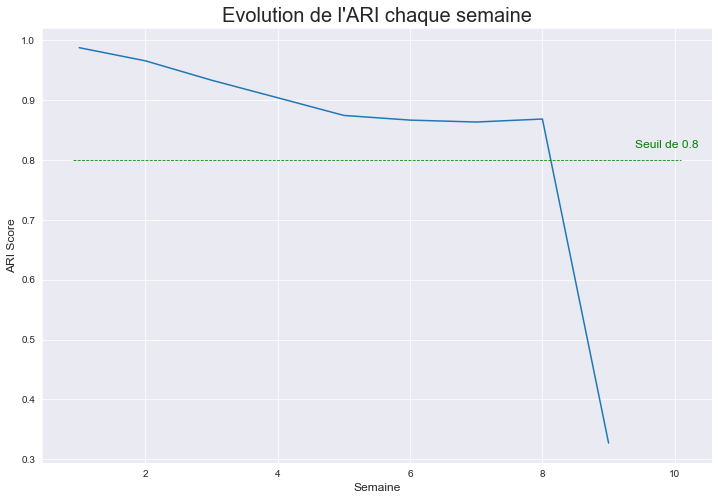

In [35]:
# Visualisation de l'évolution du score ARI
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), ari_scores)
plt.hlines(0.8, 0.9, 10.1, color='green', linestyle='--', linewidth=0.8)
plt.text(9.4, 0.82, 'Seuil de 0.8', color='green', fontsize=12)
plt.xlabel('Semaine', fontsize=12)
plt.ylabel('ARI Score', fontsize=12)
plt.title("Evolution de l'ARI chaque semaine", fontsize=20)
plt.show()

- Nous pouvons constater qu'une mise à jour après 8 semaines est nécessaire